In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('extracted_definitions.csv')
df

In [3]:
# Columns to be used for manual and extracted definitions
manual_definitions = df['extracted_definitions'].fillna('')  # Placeholder for manual definitions
extracted_columns = [
    'zero_shot_definition',
    'contextual_casual_definition',
    'contextual_academic_definition',
    'cot_definition',
    'role_definition'
]

# Sentence-BERT (SBERT)
- Description: Sentence-BERT is a modification of the BERT model that produces fixed-size sentence embeddings, making it well-suited for comparing paragraphs or longer text segments.
- How It Works: SBERT is specifically fine-tuned for sentence-level tasks, such as sentence similarity or paraphrase identification. It modifies BERT by adding a Siamese network architecture, which allows for the comparison of sentence embeddings. SBERT is trained using supervised datasets (e.g., pairs of sentences with a similarity score) to produce embeddings optimized for comparing entire sentences or paragraphs.
- Text Comparison: SBERT produces a single fixed-length vector (sentence embedding) for an entire sentence or paragraph, representing its overall meaning. To compare two sentences or paragraphs, SBERT calculates the cosine similarity between their sentence embeddings.
- Use Case: SBERT is excellent for tasks like semantic textual similarity (STS) and can be used to compare definitions by calculating the cosine similarity between the sentence embeddings of LLM-extracted and manual definitions.



In [ ]:
pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
# Load the pre-trained SBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2') # 2sec/it, median similarity 0.53

In [9]:
def calculate_similarity(manual_def, extracted_defs):
    if pd.isna(manual_def):
        return {mode: np.nan for mode in extracted_columns}

    # Compute the sentence embedding for the manual definition
    manual_embedding = model.encode(manual_def, convert_to_tensor=True)
    similarities = {}

    # Calculate cosine similarity for each extraction mode
    for mode in extracted_columns:
        extracted_def = extracted_defs.get(mode, "")
        if pd.isna(extracted_def) or extracted_def == "":
            similarities[mode] = np.nan
        else:
            extracted_embedding = model.encode(extracted_def, convert_to_tensor=True)
            similarity = util.pytorch_cos_sim(manual_embedding, extracted_embedding).item()
            similarities[mode] = similarity

    return similarities

In [ ]:
for mode in extracted_columns:
    df[mode + '_similarity'] = np.nan

for index, row in tqdm(df.iterrows(), total=len(df)):
    result = calculate_similarity(row['extracted_definitions'], row)

    for mode in extracted_columns:
        df.at[index, mode + '_similarity'] = result[mode]

# Assess Across Multiple Modes:
- For each paper, compare the manual definition with the five automatically extracted ones using the similarity metrics.

In [11]:
similarity_columns = [
    'zero_shot_definition_similarity',
    'contextual_casual_definition_similarity',
    'contextual_academic_definition_similarity',
    'cot_definition_similarity',
    'role_definition_similarity'
]

metrics_df = df[similarity_columns].agg(['mean', 'median', 'min', 'max']).round(3)
metrics_df

,zero_shot_definition_similarity,contextual_casual_definition_similarity,contextual_academic_definition_similarity,cot_definition_similarity,role_definition_similarity
mean,0.527,0.508,0.519,0.514,0.540
median,0.548,0.525,0.516,0.532,0.557
min,0.084,0.138,0.091,0.044,0.053
max,0.940,0.895,0.876,0.880,0.895


### Performance Vizualization

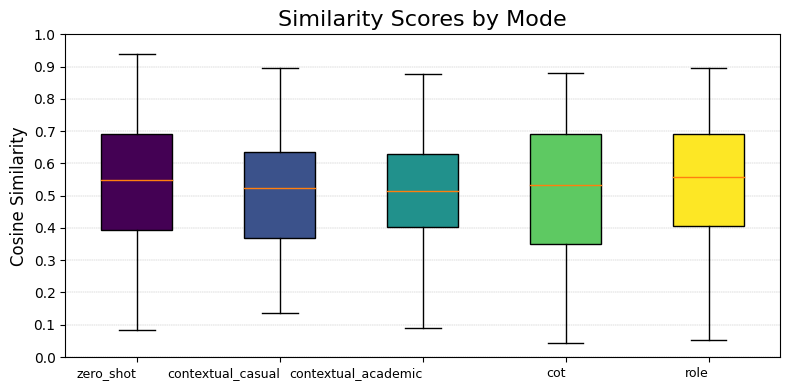

In [14]:
# boxplot for similarity scores
def create_styled_boxplot(df, similarity_columns, custom_labels):
    fig, ax = plt.subplots(figsize=(8, 4))

    data_to_plot = [df[col].dropna().values for col in similarity_columns]  # Ensures no NaNs in the boxplot
    box = ax.boxplot(data_to_plot, patch_artist=True)

    viridis = plt.get_cmap('viridis', len(similarity_columns))
    colors = viridis(np.linspace(0, 1, len(similarity_columns)))

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.3)
    ax.set_title('Similarity Scores by Mode', fontsize=16)
    ax.set_ylabel('Cosine Similarity', fontsize=12)

    ax.set_xticklabels(custom_labels, rotation=0, ha='right', fontsize=9)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    plt.tight_layout()
    plt.show()

custom_labels = ['zero_shot', 'contextual_casual', 'contextual_academic', 'cot', 'role']
create_styled_boxplot(df, similarity_columns, custom_labels)


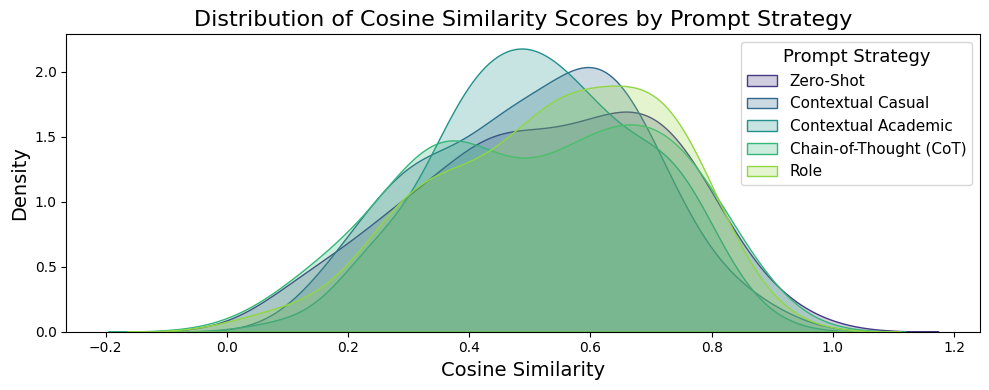

In [23]:
palette = sns.color_palette("viridis", n_colors=5)
plt.figure(figsize=(10, 4))

sns.kdeplot(df['zero_shot_definition_similarity'], fill=True, color=palette[0], label="Zero-Shot")
sns.kdeplot(df['contextual_casual_definition_similarity'], fill=True, color=palette[1], label="Contextual Casual")
sns.kdeplot(df['contextual_academic_definition_similarity'], fill=True, color=palette[2], label="Contextual Academic")
sns.kdeplot(df['cot_definition_similarity'], fill=True, color=palette[3], label="Chain-of-Thought (CoT)")
sns.kdeplot(df['role_definition_similarity'], fill=True, color=palette[4], label="Role")

plt.title('Distribution of Cosine Similarity Scores by Prompt Strategy', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.legend(title='Prompt Strategy', title_fontsize='13', fontsize='11', loc='upper right')
plt.tight_layout()
plt.show()

### Threshold-Based Evaluation


In [15]:
# function to calculate the counts of correct definitions for each threshold
def calculate_correct_definitions(df, similarity_columns, thresholds=[0.5, 0.6, 0.7]):
    results = {threshold: {} for threshold in thresholds}

    # Iterate over each threshold and calculate the counts
    for threshold in thresholds:
        for column in similarity_columns:
            correct_count = (df[column] >= threshold).sum()
            results[threshold][column] = correct_count

    results_df = pd.DataFrame(results)
    return results_df

results_df = calculate_correct_definitions(df, similarity_columns, thresholds=[0.5, 0.6, 0.7])

results_df.index = ['zero_shot', 'contextual_casual', 'contextual_academic', 'cot', 'role']
results_df.columns = ['Threshold 0.5', 'Threshold 0.6', 'Threshold 0.7']
results_df


,Threshold 0.5,Threshold 0.6,Threshold 0.7
zero_shot,62,44,25
contextual_casual,61,37,14
contextual_academic,59,36,19
cot,59,44,26
role,70,48,27


# Error Analysis:
- Qualitative Review: Randomly sample some definitions and compare them qualitatively. Manually assess how close the automatic definitions are to the manual ones in terms of meaning, identifying common errors or omissions.

In [16]:
# Function to retrieve the absolute highest and lowest cosine similarity examples
def retrieve_absolute_highest_and_lowest(df, similarity_columns, llm_definition_columns, manual_column):
    highest_similarity_info = {}
    lowest_similarity_info = {}

    max_similarity = float('-inf')
    min_similarity = float('inf')

    # Iterate over each prompt (similarity column) to find absolute highest and lowest cosine similarity
    for similarity_col, llm_definition_col in zip(similarity_columns, llm_definition_columns):
        max_value = df[similarity_col].max()
        max_idx = df[similarity_col].idxmax()

        min_value = df[similarity_col].min()
        min_idx = df[similarity_col].idxmin()

        if max_value > max_similarity:
            max_similarity = max_value
            highest_similarity_info = {
                'Prompt': similarity_col,
                'Similarity': max_value,
                'Definition (LLM)': df[llm_definition_col].iloc[max_idx],
                'Manually Extracted Definition': df[manual_column].iloc[max_idx]
            }

        if min_value < min_similarity:
            min_similarity = min_value
            lowest_similarity_info = {
                'Prompt': similarity_col,
                'Similarity': min_value,
                'Definition (LLM)': df[llm_definition_col].iloc[min_idx],
                'Manually Extracted Definition': df[manual_column].iloc[min_idx]
            }

    return highest_similarity_info, lowest_similarity_info

# List of corresponding LLM-generated definition columns
llm_definition_columns = [
    'zero_shot_definition',
    'contextual_casual_definition',
    'contextual_academic_definition',
    'cot_definition',
    'role_definition'
]

manual_column = 'extracted_definitions'

In [17]:
highest_info, lowest_info = retrieve_absolute_highest_and_lowest(df, similarity_columns, llm_definition_columns, manual_column)

# Display the results for the highest similarity
print("Highest Similarity Definition:")
print(f"Prompt: {highest_info['Prompt']}")
print(f"Highest Cosine Similarity: {highest_info['Similarity']}")
print(f"Definition (LLM): {highest_info['Definition (LLM)']}")
print(f"Manually Extracted Definition: {highest_info['Manually Extracted Definition']}")

# Display the results for the lowest similarity
print("\nLowest Similarity Definition:")
print(f"Prompt: {lowest_info['Prompt']}")
print(f"Lowest Cosine Similarity: {lowest_info['Similarity']}")
print(f"Definition (LLM): {lowest_info['Definition (LLM)']}")
print(f"Manually Extracted Definition: {lowest_info['Manually Extracted Definition']}")

Highest Similarity Definition:
Prompt: zero_shot_definition_similarity
Highest Cosine Similarity: 0.9399381875991821
Definition (LLM): ['1. **Nation Branding**: Nation branding is a process by which a nation\'s images can be created, monitored, evaluated and proactively managed in order to improve or enhance the country\'s reputation among a target international audience.\n\n2. **Nation Brand**: A nation brand is the total sum of all perceptions of a nation in the mind of international stakeholders which may include elements such as people, place, culture/language, history, food, fashion, and celebrities.\n\n3. **National Identity**: National identity is the collective understanding by a nation\'s people of the features presumed to be central and relatively permanent, which distinguish the nation from other nations.\n\n4. **National Brand Identity**: National brand identity refers to the identity of a specific "nation brand," consisting of the associations that the brand strategist see